# Differential Equations (Numerically)

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
* https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations
* http://web.mit.edu/10.001/Web/Course_Notes/Differential_Equations_Notes/node5.html
* https://en.wikipedia.org/wiki/Stiff_equation

See also a bunch of wikipedia pages on Runga-Kutta

## Imports etc...

In [2]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analytical Theory

In a differential equation, some value is related to its derivatives. The example I will use pretty much throughout is a mass on a spring. If we assume that $x = 0$ is the spring's resting length, then the force on the mass is $F = -kx$. But $f = ma$ and so,

$$
m \frac{d^2x}{dt^2} = -kx
$$

We can solve this analytically by finding some function $x(t)$ that satisfies this equation. There are many rules to help find these functions that I generally don't know, but fortunately this one is easy. Define $\omega = \sqrt{k/m}$,

$$
x(t) = C \exp(\pm i \omega t)
$$

We are not quite done - it turns out that there are two functions (see the $\pm$) that both work for $x(t)$. There is also that unknown constant $C$. The rule that solves the first is: if there are multiple solutions, any linear combination of them is also a solution. So,

$$
x(t) = C_1 \exp(i \omega t) + C_2 \exp(-i \omega t)
$$

We can simplify this as we only care about the real position,

$$
x(t) = C_1 \sin(\omega t) + C_2 \sin(-\omega t) = (C_1 + C_2) \sin(\omega t + \delta) = C \sin(\omega t + \delta)
$$

We have solved the first problem - we only have one equation for $x(t)$ - but we now have two unknownd. To find $C$ and $\delta$ we need to know the position and velocity at some point in time. Think of the solution so far as the general equation of motion for any spring. So, let's say that at $t = 0$, $x = 0$, $x' = 1$.

$$
\begin{align}
x(0) &= C \sin(\omega t + \delta) = C \sin(0 + \delta) = 0 \\
x'(t) &= \omega C \cos(\omega t + \delta) = \omega C = 1 \\
\therefore \\
\delta &= 0 \\
C &= \omega^{-1} = \sqrt{\frac{m}{k}}
\end{align}
$$

# Basic Numerical Theory + Libraries

Ok that was great... But also pretty long. I wouldn't want need to do that analytically for every equation I run into. Can we solve differential equations numerically? We can, and the reasoning is pretty simple. For the spring problem,

* We know $x$ and $x'$ at $t = 0$.
* We know $x''$ because it is just a function of $x$.
* We can advance to $t = dt$, calculate the new $x = x + x' dt$ and the new $v = v + x'' dt$

It turns out there are much better ways to do this advancing, but they all roughly look like that. See the later sections for the details of the math, for now we will focus on how you would actually do it (use a library!).

The function we want is [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp). I find the docs a little hard to understand so a short summary is here.

Imagine we have a system of first order differential equations. We can convert the spring example into a system like this by defining,

$$
\begin{align}
y_1 &= x(t) \\
y_2 &= \frac{dx}{dt}
\end{align}
$$

And therefore the differential equations are,

$$
\begin{align}
y_1' &= y_2 \\
y_2' &= \frac{d^2x}{dt^2} = -\frac{k}{m}x
\end{align}
$$

The function signature looks like, `scipy.integrate.solve_ivp(fun, t_span, y0, ...)`. Where,
* y0: Are the initial conditions. This is $y_1$ and $y_2$ in the equations above (the initial conditions)
* t_span: The time over which we want to evolve the ODE. `y0` is assumed to be the position at the first item in this tuple and the function terminates once the time is equal to the second item.
* fun(t, y): The right hand side of the differential equations. This needs to return an object the same shape as `y0`, but while `y0` returns the value at the start time, this returns the derivative (as a function of time `t`). The `y` that is passed is the current value.

An example makes this pretty clear.

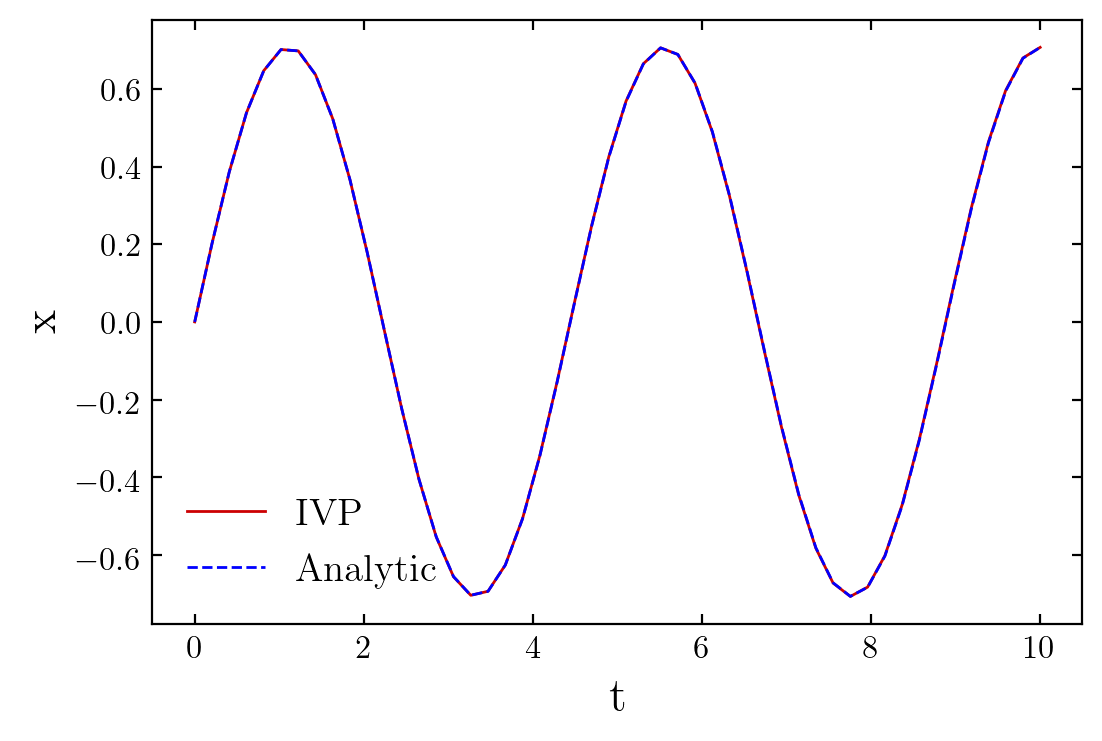

In [21]:
k = 2
m = 1
def evolve(t, y):
    return np.array([
        y[1],          # dx/dt = x'
        - y[0] * k/m   # dx'/dt = -k/m x
    ])

y0 = (0, 1) # Start at x=0, dx/dt=1
t_span = (0, 10)
res = scipy.integrate.solve_ivp(evolve, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1]))

assert res.success

_, ax = plt.subplots()
ax.plot(res.t, res.y[0], label="IVP")
ax.plot(res.t, np.sqrt(m/k) * np.sin(np.sqrt(k/m) * res.t), label="Analytic", linestyle="--")
ax.set(xlabel="t", ylabel="x")
ax.legend();

## A second example (with slightly more complicated usage solve_ivp)

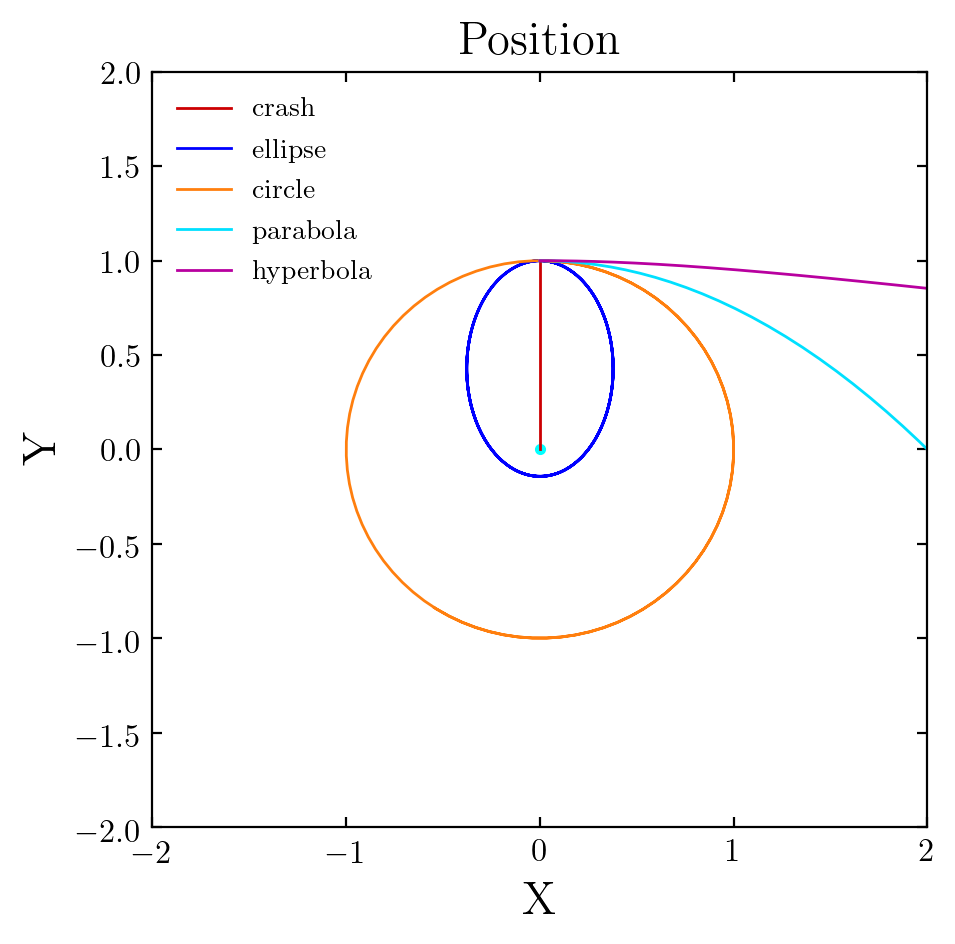

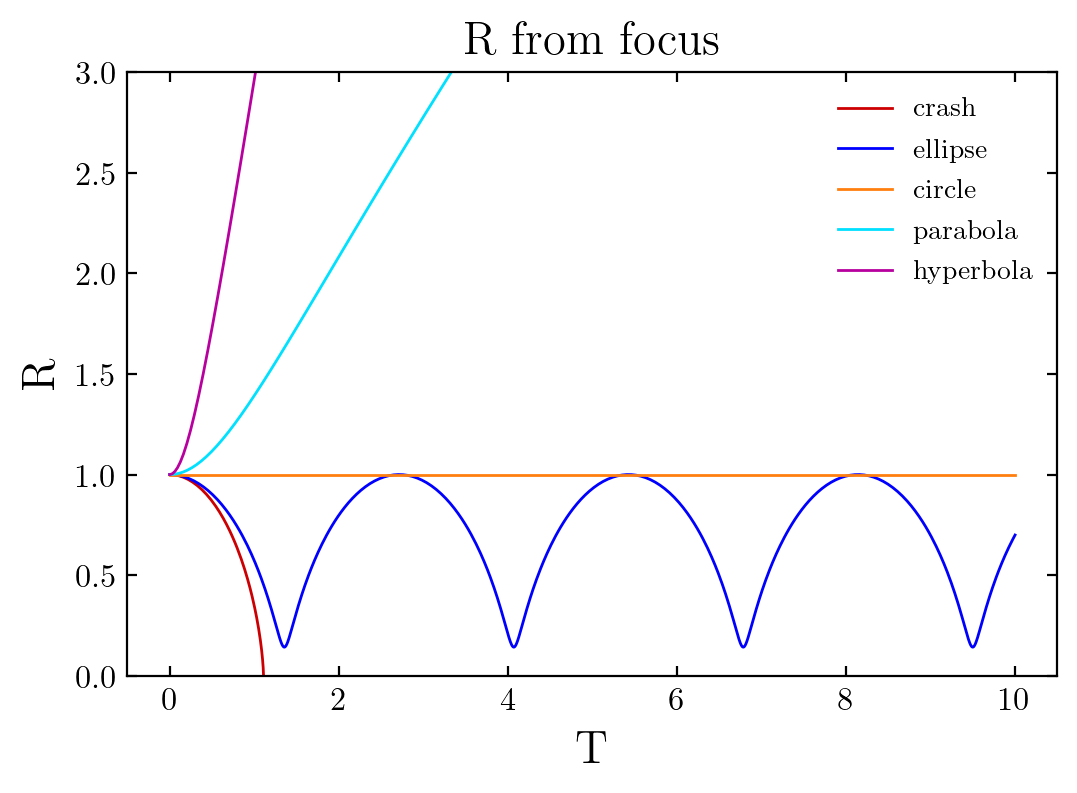

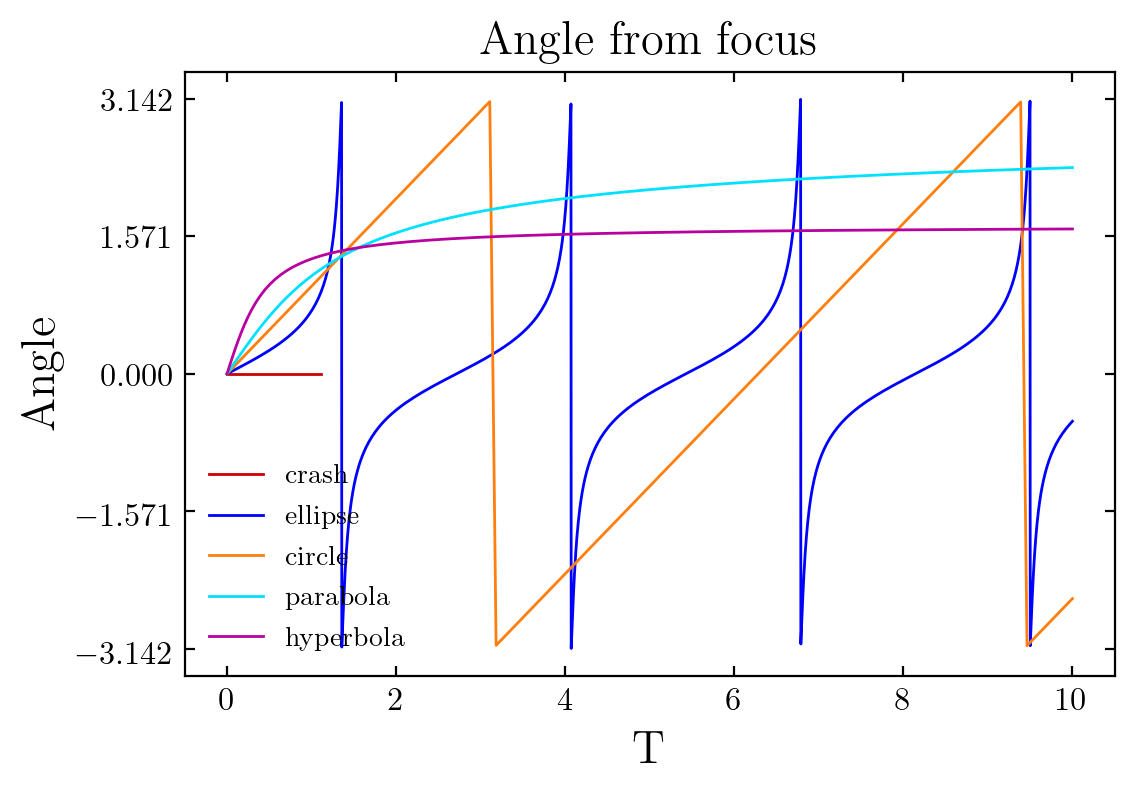

In [49]:
def evolve(t, x):
    return [
        x[2], 
        x[3], 
        -x[0] / (x[0]**2 + x[1]**2)**(3/2),
        -x[1] / (x[0]**2 + x[1]**2)**(3/2),
    ]

# Terminate if we crash into the central point
def crash(t, x):
    r = np.linalg.norm(x[:2])
    return r if r > 1e-7 else 0
crash.terminal = True

                     
_, ax = plt.subplots(figsize=(5, 5))
ax.scatter([0], [0], color="cyan")

_, rax = plt.subplots()
_, fax = plt.subplots()

for (initial_vx, label) in [
    (0, "crash"),
    (0.5, "ellipse"),
    (1, "circle"),
    (np.sqrt(2), "parabola"),
    (3, "hyperbola"),
]:
    initial_conditions = [0, 1, initial_vx, 0] # x, y, vx, vy
    t_init, t_end = 0, 10

    res = scipy.integrate.solve_ivp(evolve, (t_init, t_end), initial_conditions, rtol=1e-9, atol=1e-9, events=crash)
    assert res.success

    ax.plot(res.y[0], res.y[1], label=label)
    rax.plot(res.t, np.sqrt(res.y[0]**2 + res.y[1]**2), label=label)
    fax.plot(res.t, np.arctan2(res.y[0], res.y[1]), label=label)

ax.set(xlim=(-2, 2), ylim=(-2, 2), title="Position", xlabel="X", ylabel="Y")
rax.set(ylim=(0, 3), title="R from focus", xlabel="T", ylabel="R")
fax.set(yticks=np.linspace(-np.pi, np.pi, 5), title="Angle from focus", xlabel="T", ylabel="Angle")

ax.legend(fontsize="x-small")
rax.legend(fontsize="x-small")
fax.legend(fontsize="x-small")

# Numerical Theory

Now that we know how to do this, what is actually going on behind the scenes? It turns out there are many algos to solve these IVP with a couple of tradeoffs.

## Dynamics Example

See [this talk by Scott Tremaine](https://youtu.be/kLRbfszj6DM?list=PLTn74Qx5mPsSZsGO1AN6wfDlz7cmeTrtj&t=2844)

### Implementation of Integrators

In [23]:
year = 2*np.pi
day = year/365

In [35]:
class integrator():
    obj_dtype = [("mass", np.float64), 
                 ("x", np.float64), ("y", np.float64), 
                 ("vx", np.float64), ("vy", np.float64)]
    G = 1 # We use the same units as rebound - G = 1, distance in AU, mass in Msun, time in yr/(2*pi)
    integrator = None
    
    def __init__(self):
        self.objs = np.zeros(0, dtype=self.obj_dtype)
    
    def add_obj(self, initial_params):
        self.objs = np.append(self.objs, np.array(initial_params, dtype=self.obj_dtype))
        
    def euler_integrate(self, total_dt, step_dt):
        print("Starting from {}".format(self.objs))
        steps = int(total_dt / step_dt)
        results = np.zeros((steps + 1, len(self.objs)), dtype=self.obj_dtype)
        results[0,:] = self.objs
        
        for i in range(steps):
            accs = self._get_acc(results[i,:])
            results[i+1,:] = results[i,:]
            
            results[i+1,:]["x"] += results[i+1,:]["vx"] * step_dt
            results[i+1,:]["y"] += results[i+1,:]["vy"] * step_dt
            
            results[i+1:,]["vx"] += accs["x"] * step_dt
            results[i+1:,]["vy"] += accs["y"] * step_dt    
        return results
    
    def modified_euler_integrate(self, total_dt, step_dt):
        """
        Same as Euler except we first advance the position, then the velocity based on the acc at the new position
        """
        print("Starting from {}".format(self.objs))
        steps = int(total_dt / step_dt)
        results = np.zeros((steps + 1, len(self.objs)), dtype=self.obj_dtype)
        results[0,:] = self.objs
        
        for i in range(steps):
            results[i+1,:] = results[i,:]
            
            results[i+1,:]["x"] += results[i+1,:]["vx"] * step_dt
            results[i+1,:]["y"] += results[i+1,:]["vy"] * step_dt
            
            accs = self._get_acc(results[i+1,:])
            
            results[i+1:,]["vx"] += accs["x"] * step_dt
            results[i+1:,]["vy"] += accs["y"] * step_dt    
        return results
    
    def leapfrog_integrate(self, total_dt, step_dt):
        """
        Summarized as kick-drift-kick. 
        1) Update V by half a timestep (using acc at the initial pos)
        2) Use that V to drift for full timestep
        3) Update V by the second half timestep (using acc at the ending pos)
        """
        print("Starting from {}".format(self.objs))
        steps = int(total_dt / step_dt)
        results = np.zeros((steps + 1, len(self.objs)), dtype=self.obj_dtype)
        results[0,:] = self.objs
        
        for i in range(steps):
            results[i+1,:] = results[i,:]
            
            # Kick
            accs = self._get_acc(results[i+1,:])
            results[i+1:,]["vx"] += accs["x"] * step_dt/2
            results[i+1:,]["vy"] += accs["y"] * step_dt/2
            
            # Drift
            results[i+1,:]["x"] += results[i+1,:]["vx"] * step_dt
            results[i+1,:]["y"] += results[i+1,:]["vy"] * step_dt
            
            # Kick
            accs = self._get_acc(results[i+1,:])
            results[i+1:,]["vx"] += accs["x"] * step_dt/2
            results[i+1:,]["vy"] += accs["y"] * step_dt/2
        return results
    
    def runge_kutta_4_integrate(self, total_dt, step_dt):
        """
        See http://spiff.rit.edu/richmond/nbody/OrbitRungeKutta4.pdf
        I think there might be a bug in this because it is pretty bad...

        * kv1 - acc(x_i)
        * kr1 - v_i
        
        * kv2 - acc(x_i + kr1 * dt / 2) - the a with the estimated midpoint.
        * kr2 - v_i + kv1 * dt / 2 - the vel with the estimated midpoint
        
        * kv3 - acc(x_i + kr2 * dt / 2) - same as 2 but with a different midpoint
        * kr3 - v_i + kv2 * dt/ 2
        
        * kv4 - acc(x_i + kr3 * dt) - the a at the expected endpoint
        * kr4 - v_i + kv3 * dt
        
        Then to get the final positions:
        v_(i+1) = v_i * (kv1 + 2*kv2 + 3*kv3 + kv4) * dt / 6
        """
        print("Starting from {}".format(self.objs))
        steps = int(total_dt / step_dt)
        results = np.zeros((steps + 1, len(self.objs)), dtype=self.obj_dtype)
        results[0,:] = self.objs
        
        for i in range(steps):
            results[i+1,:] = results[i,:]
            
            kv1 = self._rv(self._get_acc(results[i+1,:]))
            kr1 = self._rv(results[i+1,:][["vx", "vy"]])
            
            kv2 = self._rv(self._get_acc(
                self._rv2(results[i+1,:], kr1 * step_dt / 2 # estimated midpoint position
            )))
            kr2 = self._rv(results[i+1,:][["vx", "vy"]]) + kv1 * step_dt / 2
            
            kv3 = self._rv(self._get_acc(
                self._rv2(results[i+1,:], kr2 * step_dt / 2 # estimated midpoint position
            )))
            kr3 = self._rv(results[i+1,:][["vx", "vy"]]) + kv2 * step_dt / 2
            
            kv4 = self._rv(self._get_acc(
                self._rv2(results[i+1,:], kr3 * step_dt
            )))
            kr4 = self._rv(results[i+1,:][["vx", "vy"]]) + kv3 * step_dt
            
            
            v_delta = (kv1 + 2*kv2 + 3*kv3 + kv4) * step_dt / 6
            r_delta = (kr1 + 2*kr2 + 3*kr3 + kr4) * step_dt / 6
            # Kick
            
            results[i+1:,]["vx"] += v_delta[:,0]
            results[i+1:,]["vy"] += v_delta[:,1]
            
            # Drift
            results[i+1,:]["x"] += r_delta[:,0]
            results[i+1,:]["y"] += r_delta[:,1]
        return results
    
    def integrate(self, total_dt, step_dt):
        assert self.integrator is not None, "Must set integrator first!"
        return self.integrator(total_dt, step_dt)
    
    def set_integrator(self, integrator):
        self.integrator = integrator
        
    def _get_acc(self, objs):
        accs = np.zeros(len(objs), dtype=[("x", np.float64), ("y", np.float64)])
        for i in range(len(objs)):
            other_objs = objs[np.arange(len(objs)) != i]
            dx = other_objs["x"] - objs[i]["x"]
            dy = other_objs["y"] - objs[i]["y"]
            dists = np.sqrt(np.power(dx, 2) + np.power(dy, 2))
            acc = self.G * other_objs["mass"] / dists**3
            blah = np.sum(acc * (dx, dy), axis=1)
            accs[i]["x"] = blah[0]
            accs[i]["y"] = blah[1]
        return accs

    def _rv(self, arr):
        return arr.ravel().view(np.float64).reshape((-1, 2))
    
    def _rv2(self, res, delta_x):
        tmp = res.copy().ravel().view(np.float64).reshape((-1, 5))
        tmp[:,1:3] += delta_x
        return tmp.view(self.obj_dtype)

### Comparison

In [44]:
sim = integrator()
sim.add_obj((1, 0, 0, 0, 0))
sim.add_obj((1e-3, 1, 0, 0, 1))


sim.set_integrator(sim.runge_kutta_4_integrate)

#### Single Orbit

Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]


/home/christopher/.virtualenvs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:162: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]


No handles with labels found to put in legend.


[Text(0, 0.5, 'Fractional error'), Text(0.5, 0, 'theta')]

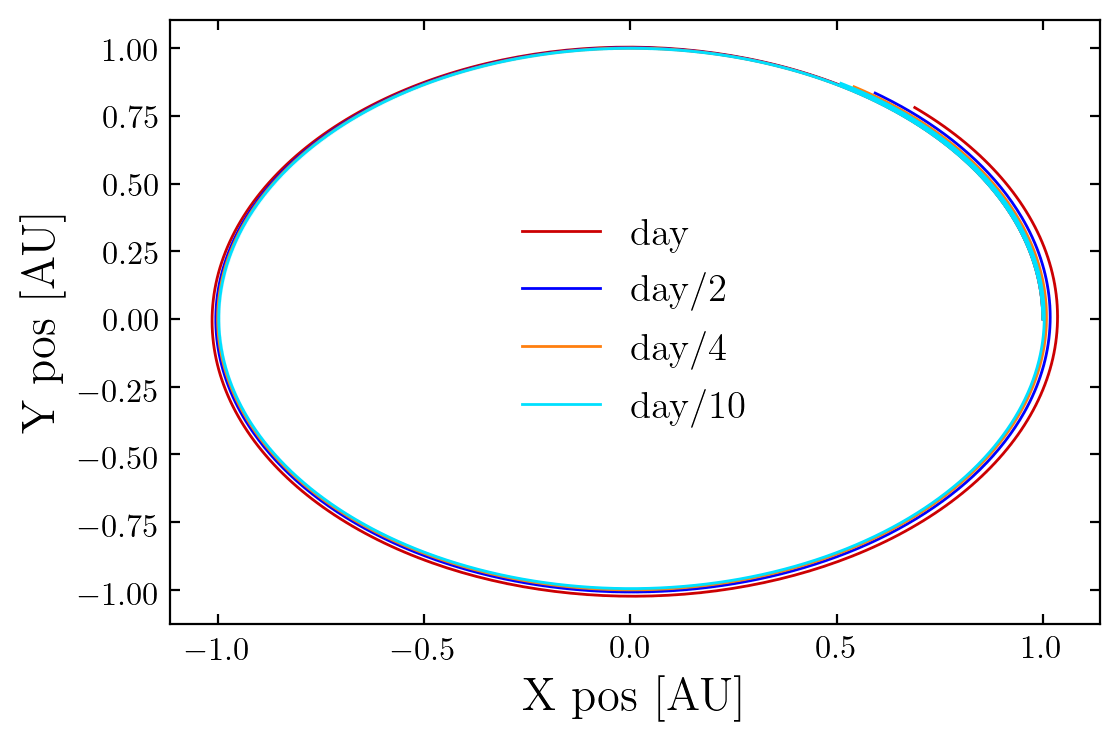

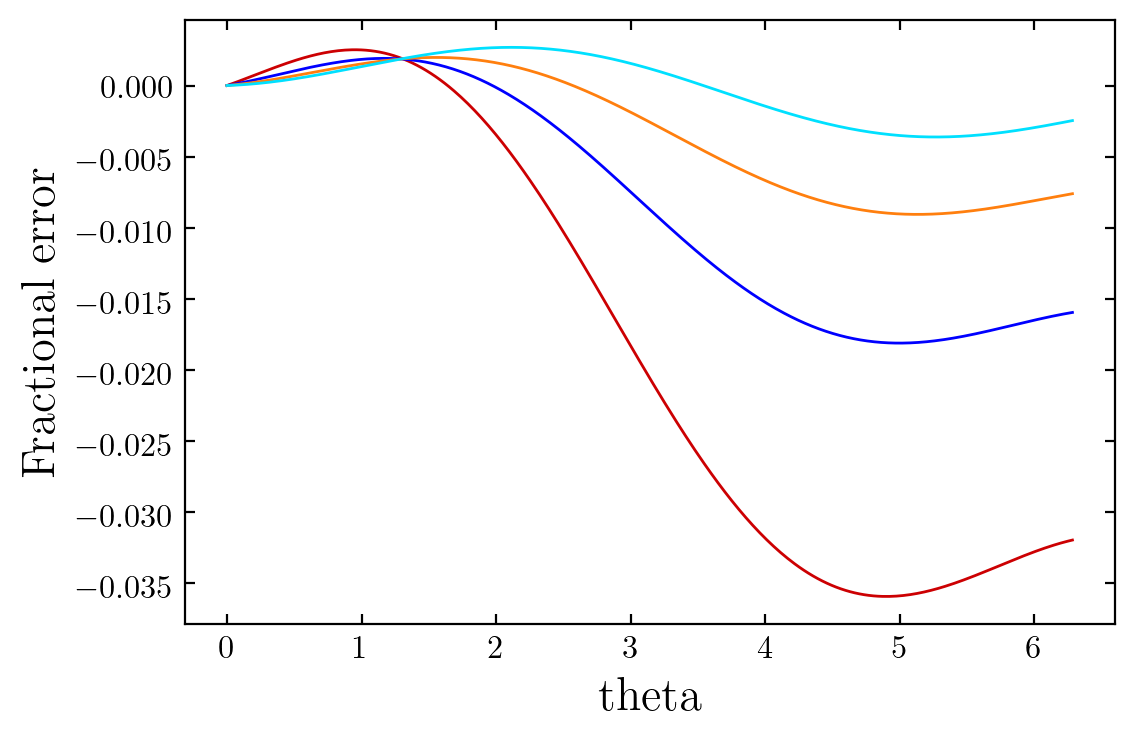

In [45]:
end = 2*np.pi
stepsizes = [day, day/2, day/4, day/10]#, day/100]
labels = ["day", "day/2", "day/4", "day/10"]#, "day/100"]

_, ax = plt.subplots()
_, ax2 = plt.subplots()

for (step, lab) in zip(stepsizes, labels):
    results = sim.integrate(end, step)
    ax.plot(results[:,1]["x"], results[:,1]["y"], marker=".", markersize=0.02, label=lab)
    
    energy = np.sum(0.5 * results["mass"] * (results["vx"]**2 + results["vy"]**2), axis=1)
    ax2.plot(np.linspace(0, end, len(energy)), (energy - energy[0]) / energy[0])
    
ax.legend()
ax.set(xlabel="X pos [AU]", ylabel="Y pos [AU]")
ax2.legend()
ax2.set(ylabel="Fractional error", xlabel="theta")

#### Multiple Orbits

Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]


/home/christopher/.virtualenvs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:162: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]


[Text(0, 0.5, 'Fractional error'), Text(0.5, 0, 'theta')]

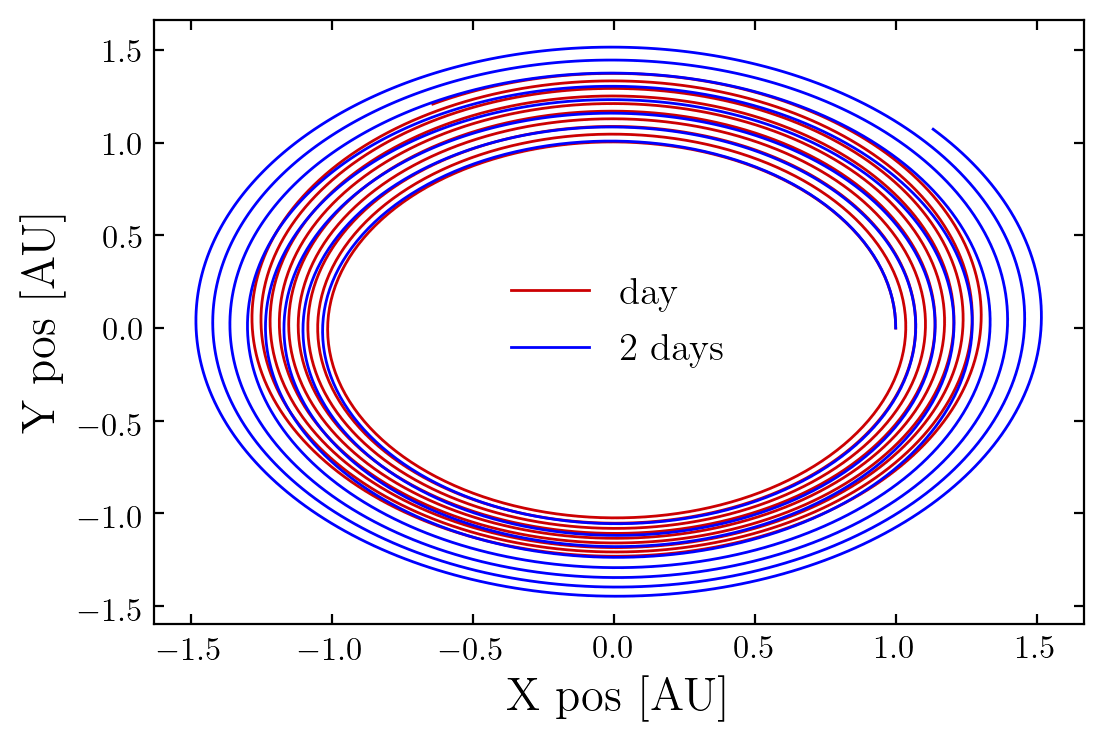

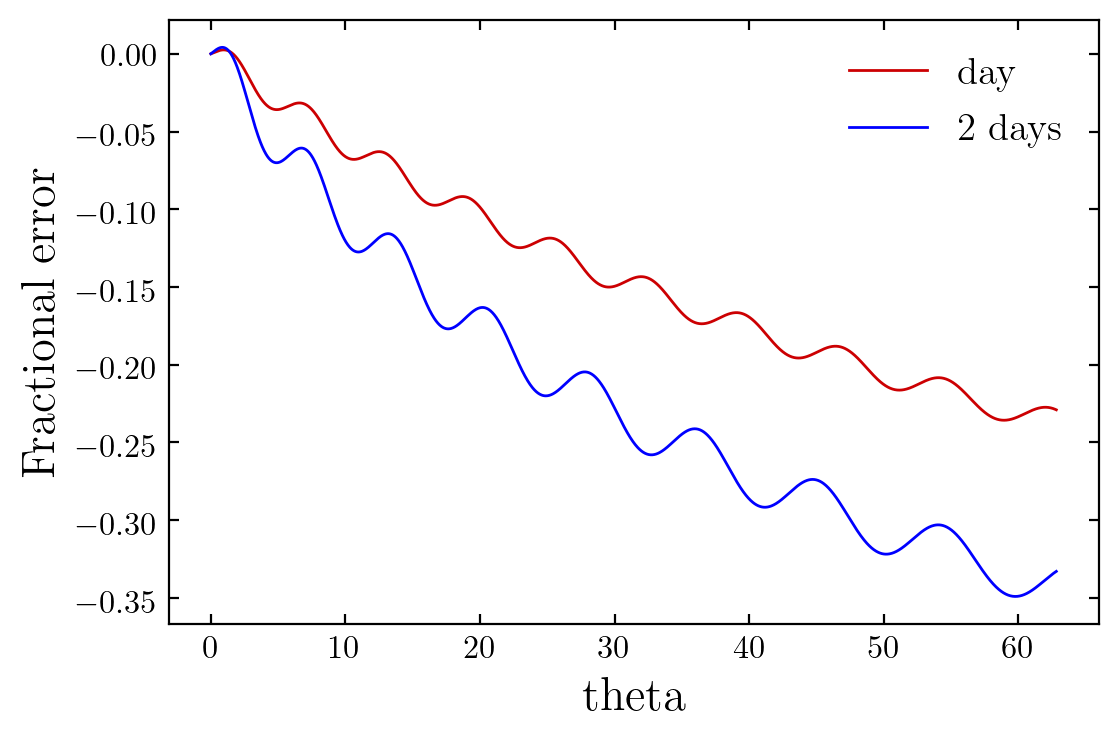

In [46]:
end = 2*np.pi * 10
stepsizes = [day, day*2]
labels = ["day", "2 days"]

_, ax = plt.subplots()
_, ax2 = plt.subplots()

for (step, lab) in zip(stepsizes, labels):
    results = sim.integrate(end, step)
    ax.plot(results[:,1]["x"], results[:,1]["y"], marker=".", markersize=0.02, label=lab)
    
    energy = np.sum(0.5 * results["mass"] * (results["vx"]**2 + results["vy"]**2), axis=1)
    ax2.plot(np.linspace(0, end, len(energy)), (energy - energy[0]) / energy[0], label=lab)
    
ax.legend()
ax.set(xlabel="X pos [AU]", ylabel="Y pos [AU]")
ax2.legend()
ax2.set(ylabel="Fractional error", xlabel="theta")

## Qualities of different integrators

From the dynamics example we can see that the different integrators have different qualities.

...TODO!